In [100]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, pearsonr
from scipy.special import rel_entr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

figsize=(30,15)
fontsize = 50
export_dir = './plots_bar/'
load_dir = './data_tournament/'
filetype = 'pdf'

env_name = ['chicken', 'pure_coordination', 'prisoners_dilemma', 'stag_hunt']
row_name = ['S', 'M', 'L', 'O']
col_name = ['SP5', 'PP3', 'PP5']

row_name_dict = {'S': 'Small',
                 'M': 'Medium',
                 'L': 'Large',
                 'O': 'Obstacle'}

col_name_dict = {'SP5': 'SP',
                 'PP3': 'PP 3 Seeds',
                 'PP5': 'PP 5 Seeds',
                 'FCP3': 'FCP 3 Seeds',
                 'FCP5': 'FCP 5 Seeds'}
env_name_dict = {'chicken': 'Chicken',
                 'pure_coordination': 'Pure\nCoordination',
                 'prisoners_dilemma': 'Prisoners\nDilemma',
                 'stag_hunt': 'Stag\nHunt'}

sns.set()
sns.set_context("paper")
sns.set(rc={'figure.figsize':figsize})
sns.set_style("whitegrid")
palette = ["#f8ac8c", "#9ac9db", "#2878b5"]

In [101]:
rewards = np.empty((len(row_name), len(col_name), 2)) # mean & variance
raw_df = pd.DataFrame()
for env in np.arange(len(env_name)):
    for row in np.arange(len(row_name)):
        for col in np.arange(len(col_name)):
            loaded = np.load(os.path.join(load_dir,env_name[env]+'_'+row_name[row]+'_'+col_name[col]+'.npz'))
            # print(np.shape(loaded['rewards']))
            current_reward = np.mean(loaded['rewards'], axis=1).flatten()
            temp_df = pd.DataFrame({'rewards': current_reward, 
                                    'config': np.repeat(row_name_dict[row_name[row]], len(current_reward)),
                                    'method': np.repeat(col_name_dict[col_name[col]], len(current_reward)),
                                    'env': np.repeat(env_name[env], len(current_reward))})
            raw_df = raw_df._append(temp_df, ignore_index=True)
raw_df

,rewards,config,method,env
0,75.353214,Small,SP,chicken
1,72.685714,Small,SP,chicken
2,83.537659,Small,SP,chicken
3,75.075959,Small,SP,chicken
4,75.953361,Small,SP,chicken
...,...,...,...,...
2875,54.610093,Obstacle,PP 5 Seeds,stag_hunt
2876,47.114800,Obstacle,PP 5 Seeds,stag_hunt
2877,51.559246,Obstacle,PP 5 Seeds,stag_hunt
2878,49.415450,Obstacle,PP 5 Seeds,stag_hunt


In [102]:
method_dict = {}
for env in env_name:
    env_name_list = [f'{env}_{_}' for _ in row_name]
    load_dir_list = [f'./data_index/{_}_5M_2.npz' for _ in env_name_list]
    if env == 'pure_coordination':
        load_dir_list = [f'./data_index/{_}_5M.npz' for _ in env_name_list]

    index = []
    method = []

    for load_dir in load_dir_list:
        loaded = np.load(load_dir)
        rewards = loaded['rewards']
        checkpoints = loaded['checkpoints']
        rewards = rewards[0,...] # only have 1 evaluation seed
        mean_rewards = np.mean(rewards,axis=0)
        # np.shape(mean_rewards)
        index_list = []
        for seed in [0,1,2,3,4]:
            current_seed_list = []
            for eval_gen in range(np.shape(rewards)[0]):
                row_rewards = rewards[eval_gen,seed,:,:,0]
                col_rewards = rewards[eval_gen,seed,:,:,1]
                # start = np.min(row_rewards)
                # end = np.max(row_rewards)
                start = 0
                end = 100
                num_bins = 50
                # marginal distribution
                total_rewards = row_rewards.flatten()
                marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
                marginal_distribution = marginal_hist / sum(marginal_hist)
                # KL divergence
                KL_divergence = np.zeros(len(row_rewards))
                for i in range(len(row_rewards)):
                    hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
                    distribution = hist / sum(hist)
                    KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
                # index
                cur_index = sum(KL_divergence)/len(KL_divergence)
                index_list.append(cur_index)
                current_seed_list.append(cur_index)
        # print(f'{load_dir} Avg: {np.mean(index_list):.3f} +/- {np.std(index_list):.2f}')
        index.append(np.mean(index_list))
    low_bound = np.mean(index)-np.std(index) 
    upper_bound = np.mean(index)+np.std(index)

    count = 0
    for i in index:
        if i < low_bound:
            method.append('SP5')
            count += 1
        elif i > upper_bound: 
            method.append('PP5')
            count -= 1
        else:
            method.append('PP3')
    if count != 0:
        if count > 0: # need one more PP5
            method[np.argmax(index)] = 'PP5'
        else:  # need one more SP
            method[np.argmin(index)] = 'SP5'

    ###
    if env == 'pure_coordination':
        method = ['PP5', 'PP3', 'PP3', 'SP5']
    ###

    method_dict[env] = method
    print(f'{env}\n\t Index: {index}\n\t One-sigma: [{low_bound:.4f}, {upper_bound:.4f}]\n\t Methods: {method}')

chicken
	 Index: [1.2912804587670803, 1.3643270497219742, 1.4384792955070722, 1.2271607360569754]
	 One-sigma: [1.2512, 1.4094]
	 Methods: ['PP3', 'PP3', 'PP5', 'SP5']
pure_coordination
	 Index: [1.1165165733776352, 1.0706197944499463, 0.9751619484862679, 0.9761551787160944]
	 One-sigma: [0.9735, 1.0958]
	 Methods: ['PP5', 'PP3', 'PP3', 'SP5']
prisoners_dilemma
	 Index: [1.3768534893524849, 1.385400101613565, 1.1799314745893448, 1.0997269286408466]
	 One-sigma: [1.1365, 1.3845]
	 Methods: ['PP3', 'PP5', 'PP3', 'SP5']
stag_hunt
	 Index: [1.3970032036560673, 1.4311894126334077, 1.424334869371051, 1.063269551718942]
	 One-sigma: [1.1750, 1.4829]
	 Methods: ['PP3', 'PP5', 'PP3', 'SP5']


In [103]:
comp_df = pd.DataFrame()
for env in np.arange(len(env_name)):
    uniform_rewards = np.array([])
    allocated_rewards = np.array([])
    for i in np.arange(len(row_name)):
        method = method_dict[env_name[env]][i]
        normalize_factor = np.mean(raw_df.loc[(raw_df['env'] == env_name[env]) & (raw_df['method'] == col_name_dict[col_name[0]]) & (raw_df['config'] == row_name_dict[row_name[i]])]['rewards'].to_numpy())
        
        cur_uniform_rewards = np.sort(raw_df.loc[(raw_df['env'] == env_name[env]) & (raw_df['method'] == 'PP 3 Seeds') & (raw_df['config'] == row_name_dict[row_name[i]])]['rewards'].to_numpy())[-30:]
        cur_allocated_rewards = np.sort(raw_df.loc[(raw_df['env'] == env_name[env]) & (raw_df['method'] == col_name_dict[method]) & (raw_df['config'] == row_name_dict[row_name[i]])]['rewards'].to_numpy())[-30:]
        # if col_name_dict[method] == 'SP':
        #     cur_allocated_rewards = np.sort(np.average(cur_allocated_rewards.reshape(-1, 20), axis=1))[-1]

        uniform_rewards = np.append(uniform_rewards, cur_uniform_rewards/normalize_factor)
        allocated_rewards = np.append(allocated_rewards, cur_allocated_rewards/normalize_factor)
    temp_df = pd.DataFrame({'rewards': np.append(uniform_rewards, allocated_rewards),
                'label': np.repeat(['uniform', 'allocated'], [len(uniform_rewards), len(allocated_rewards)]),
                'env': np.repeat(env_name_dict[env_name[env]], len(uniform_rewards)+len(allocated_rewards)),})
    comp_df = comp_df._append(temp_df, ignore_index=True) 
comp_df 

,rewards,label,env
0,0.901461,uniform,Chicken
1,0.917644,uniform,Chicken
2,0.987999,uniform,Chicken
3,1.002967,uniform,Chicken
4,1.003365,uniform,Chicken
...,...,...,...
955,1.118373,allocated,Stag\nHunt
956,1.136220,allocated,Stag\nHunt
957,1.156848,allocated,Stag\nHunt
958,1.189291,allocated,Stag\nHunt


In [107]:
for env in env_name:
    F, p = f_oneway(comp_df.loc[(comp_df['env'] == env_name_dict[env]) & (comp_df['label'] == 'uniform')]['rewards'].to_numpy(),
        comp_df.loc[(comp_df['env'] == env_name_dict[env]) & (comp_df['label'] == 'allocated')]['rewards'].to_numpy())
    print(f'{env}:  \t F-statistic: {F:.5}\tp-value: {p:.3e}')

chicken:  	 F-statistic: 14.174	p-value: 2.100e-04
pure_coordination:  	 F-statistic: 28.276	p-value: 2.422e-07
prisoners_dilemma:  	 F-statistic: 0.58124	p-value: 4.466e-01
stag_hunt:  	 F-statistic: 7.0212	p-value: 8.595e-03


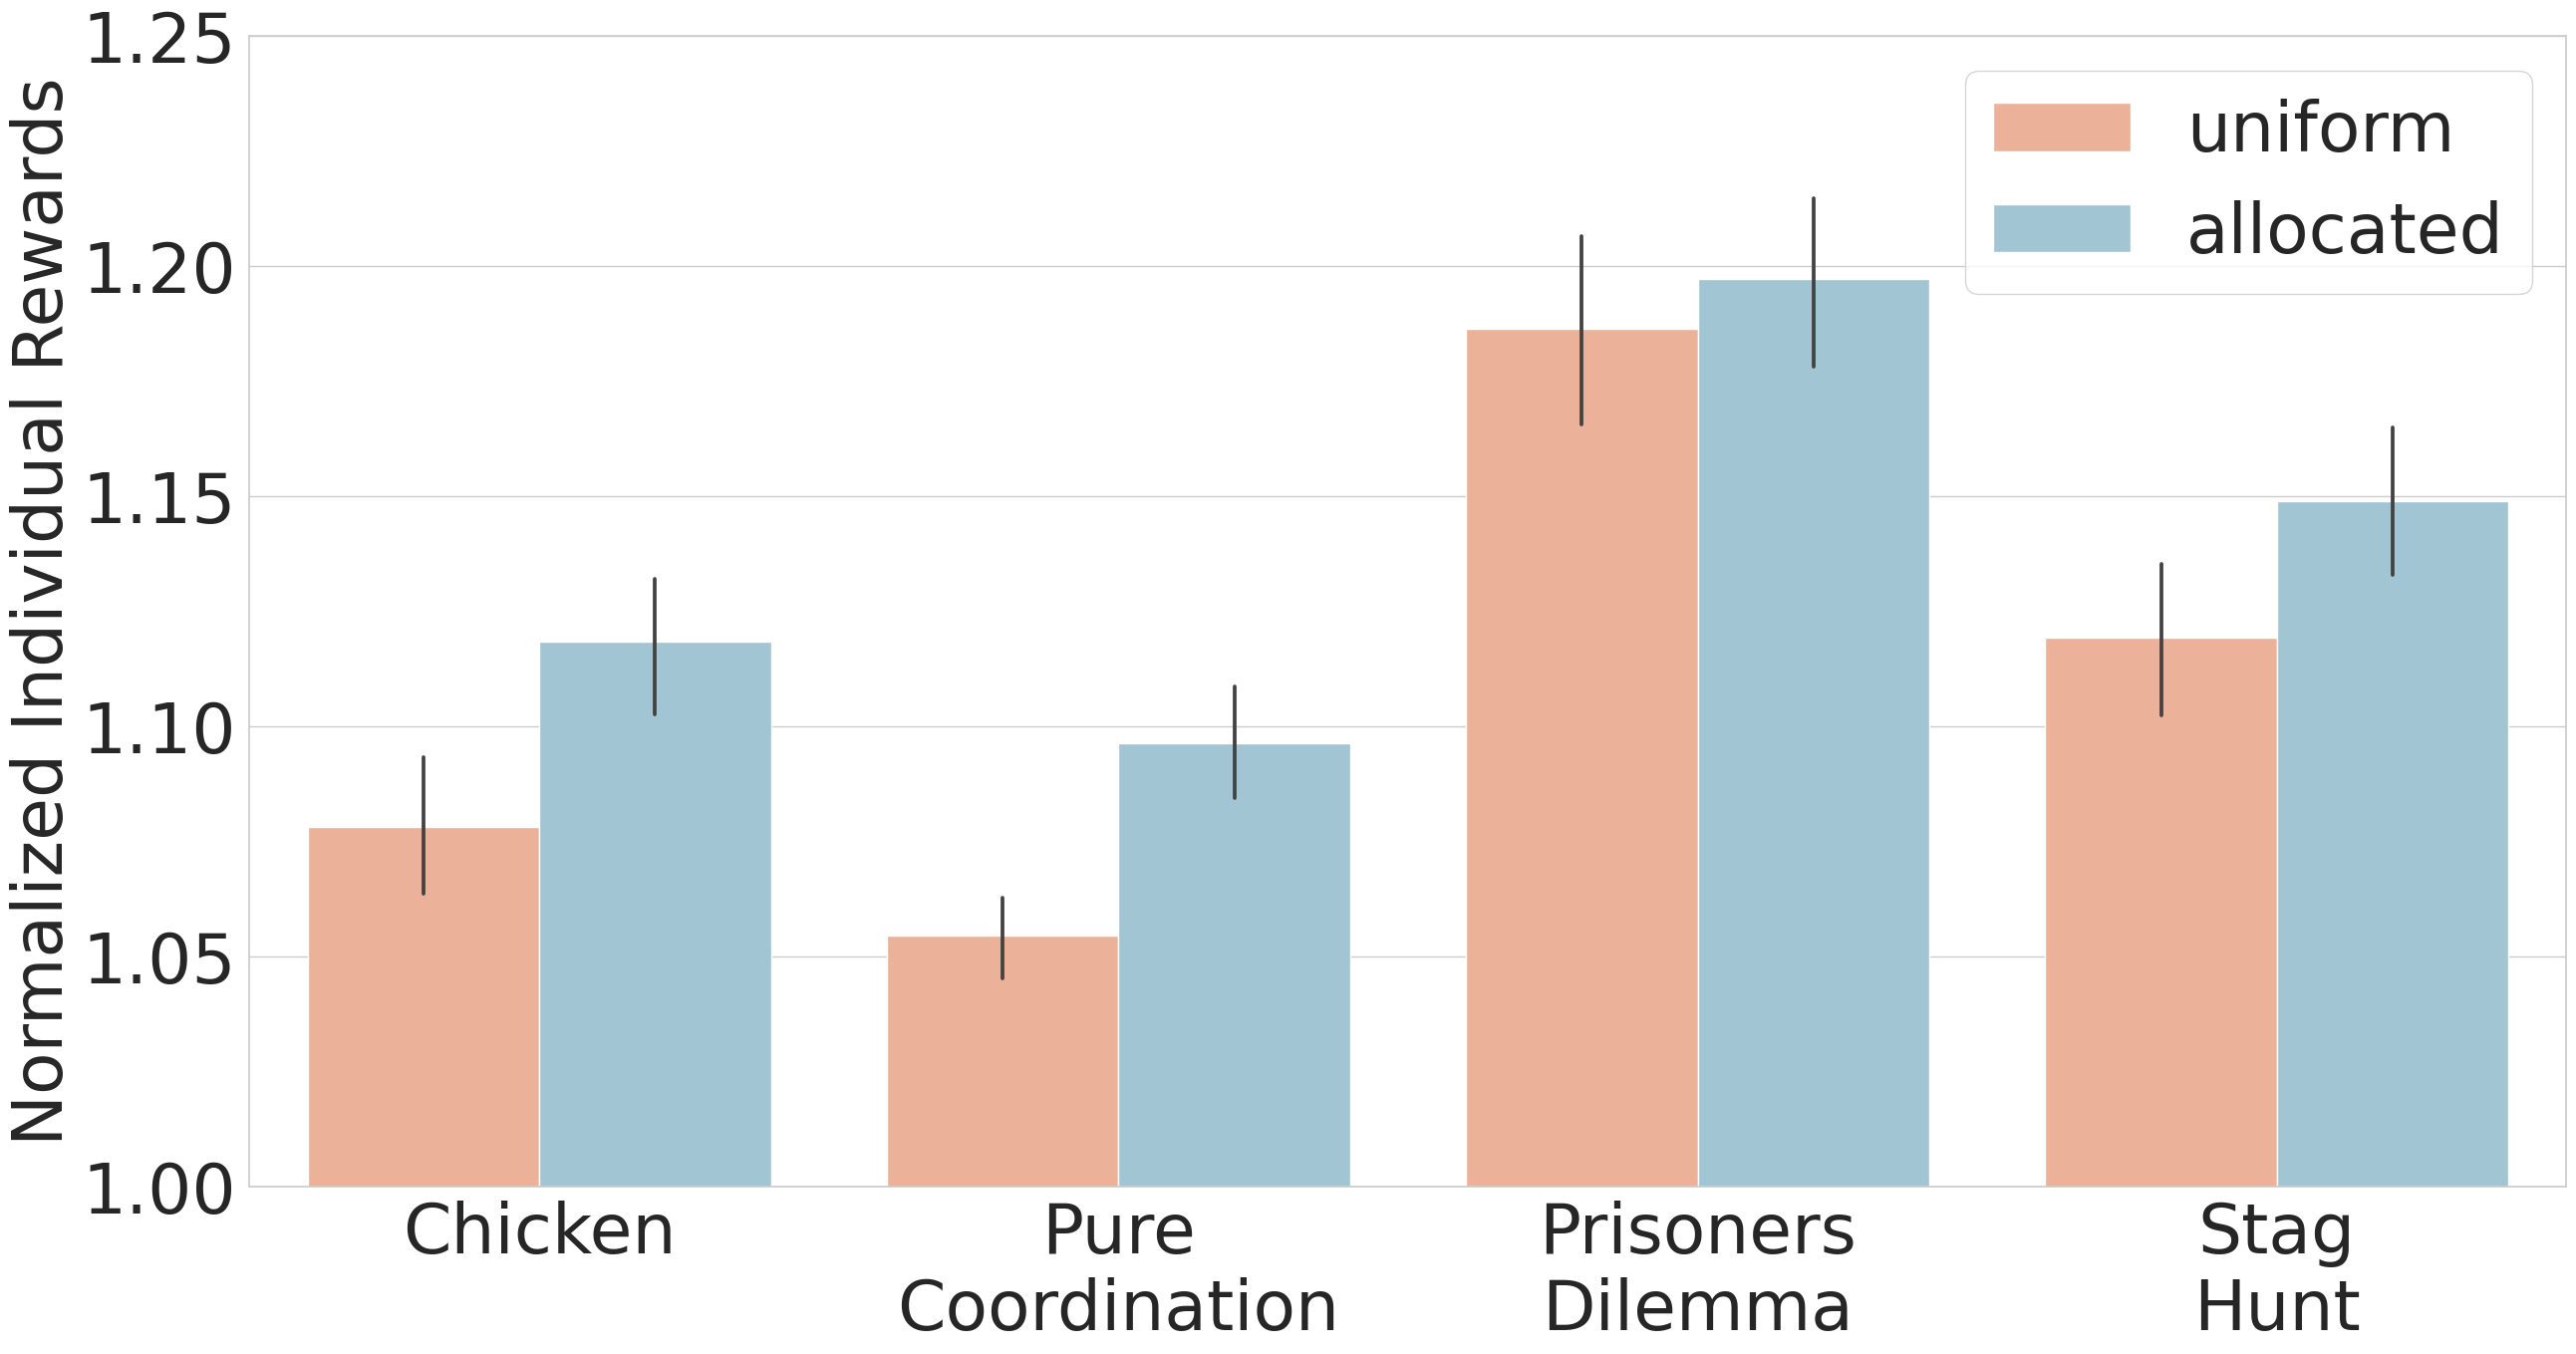

In [105]:
ax = sns.barplot(data=comp_df, x='env', y='rewards', hue='label', palette=sns.color_palette(palette,2))

ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('Normalized Individual Rewards', fontsize=fontsize)
# ax.set_title((env_name.replace('_',' ')+' Tournament').title(), fontsize=fontsize, y=1.05)
ax.legend(fontsize=fontsize, loc='best')
ax.set_ylim([1,1.25])

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(export_dir, 'resource_allocation.'+filetype), bbox_inches='tight')